## This Notebook Demonstrate the Calssification of Covid and Normal Cases Using Chest X-ray (CXR) Images

Some part of this program is taken from the follwoing link
https://machinelearningknowledge.ai/keras-implementation-of-vgg16-architecture-from-scratch-with-dogs-vs-cat-data-set/

This notebook contains three major section
1. Building and Train the VGG16 model
2. Performance test of the trained model and converting it into JSON format
3. Infererencing the program (future use)

### 1. Build the VGG16 model and trian the model

#### Import all the necessary libraries

In [1]:
import cv2
import numpy as np
import os
import shutil
from glob import glob

import matplotlib.pyplot as plt

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16

import keras

#### Split the dataset into train and test (Skip this section if the dataset is already split)

In [6]:
image_files_covid = glob("cxr_roi/covid/*.png")
image_files_normal = glob("cxr_roi/normal/*.png")

In [7]:
ts = 0.8 #train split

In [8]:
np.random.shuffle(image_files_normal)
train_files_normal = image_files_normal[:int(len(image_files_normal)*ts)]
val_files_normal = image_files_normal[int(len(image_files_normal)*ts):int(len(image_files_normal)*(ts+0.1))]
test_files_normal = image_files_normal[int(len(image_files_normal)*(ts+0.1)):]
print('train: {}, val: {}, test: {}'.format(len(train_files_normal), len(val_files_normal), len(test_files_normal)))

train: 8153, val: 1019, test: 1020


In [9]:
np.random.shuffle(image_files_covid)
train_files_covid = image_files_covid[:int(len(image_files_covid)*ts)]
val_files_covid = image_files_covid[int(len(image_files_covid)*ts):int(len(image_files_covid)*(ts+0.1))]
test_files_covid = image_files_covid[int(len(image_files_covid)*(ts+0.1)):]
print('train: {}, val: {}, test: {}'.format(len(train_files_covid), len(val_files_covid), len(test_files_covid)))

train: 2891, val: 361, test: 362


In [10]:
# Set up the directories 
work_dir = os.path.join(os.getcwd(), 'covid_vs_nor')
train_dir = os.path.join(work_dir, 'train')
val_dir = os.path.join(work_dir, 'val')
test_dir = os.path.join(work_dir, 'test')

if not os.path.exists(work_dir):
    #shutil.rmtree(work_dir)
    os.mkdir(work_dir)

    os.mkdir(train_dir)
    os.mkdir(val_dir)
    os.mkdir(test_dir)

    os.mkdir(os.path.join(train_dir, 'covid'))
    os.mkdir(os.path.join(train_dir, 'normal'))

    os.mkdir(os.path.join(val_dir, 'covid'))
    os.mkdir(os.path.join(val_dir, 'normal'))

    os.mkdir(os.path.join(test_dir, 'covid'))
    os.mkdir(os.path.join(test_dir, 'normal'))

In [11]:
# copy the images to the respective folder
covid_files = [train_files_covid, val_files_covid, test_files_covid]
dirs = [train_dir, val_dir, test_dir]

for i in range(3):
    for file in covid_files[i]:
        img = cv2.imread(file)
        file_name = os.path.basename(file)
        cv2.imwrite(os.path.join(dirs[i], 'covid', file_name), img)
        
normal_files = [train_files_normal, val_files_normal, test_files_normal]
dirs = [train_dir, val_dir, test_dir]

for i in range(3):
    for file in normal_files[i]:
        img = cv2.imread(file)
        file_name = os.path.basename(file)
        cv2.imwrite(os.path.join(dirs[i], 'normal', file_name), img)

#### Set up the work directories

In [2]:
train_dir = "covid_vs_nor/train"
val_dir = "covid_vs_nor/val"
test_dir = "covid_vs_nor/test"
class_names=os.listdir(train_dir)
print(class_names)

['covid', 'normal']


#### Display sample images

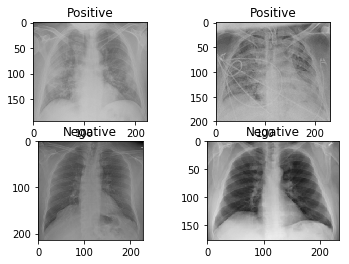

In [3]:
f, axr = plt.subplots(2,2)

axr[0][0].imshow(cv2.imread(np.random.choice(glob("cxr_roi/covid/*.png"))))
axr[0][0].set_title("Positive")

axr[0][1].imshow(cv2.imread(np.random.choice(glob("cxr_roi/covid/*.png"))))
axr[0][1].set_title("Positive")

axr[1][0].imshow(cv2.imread(np.random.choice(glob("cxr_roi/normal/*.png"))))
axr[1][0].set_title("Negative")

axr[1][1].imshow(cv2.imread(np.random.choice(glob("cxr_roi/normal/*.png"))))
axr[1][1].set_title("Negative")

plt.show()

#### Keras data generator

In [4]:
train_datagen = ImageDataGenerator(zoom_range=0.15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   #vertical_flip=True,
                                   rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [5]:
bs = 16
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224,224),
                                                    batch_size=bs,
                                                    shuffle=True,
                                                    class_mode='categorical')

val_data = train_datagen.flow_from_directory(val_dir, target_size=(224,224),
                                                  batch_size=bs,
                                                  shuffle=True,
                                                  class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir, target_size=(224,224),
                                                  batch_size=bs,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 11044 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1382 images belonging to 2 classes.


#### Display one batch of train images

In [6]:
train_batch = next(train_data)
print(train_batch[0].shape) # batch[0] is the images, batch[1] are the labels

(16, 224, 224, 3)


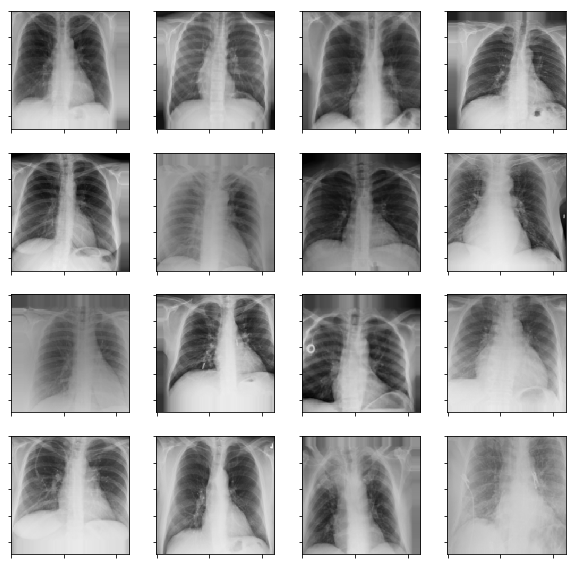

In [7]:
f,ax = plt.subplots(4,4, figsize=(10,10))
for i in range(16):
    img = train_batch[0][i]  # this is the first image  batch[0][1] would be the next image
    ax[i//4][i%4].imshow(img, cmap='gray')
    ax[i//4][i%4].set_xticklabels([])
    ax[i//4][i%4].set_yticklabels([])
plt.show()

#### Build the VGG16 model

In [8]:
def VGG_16():
    model = Sequential()
    
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    
    model.add(Flatten(name='flatten'))
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dense(2, activation='softmax', name='output'))
    
    return model

#### Compile the model

In [9]:
model = VGG_16()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [10]:
from keras.optimizers import SGD, Adam
opt = Adam(1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#### Set up early stopping criteria and modelcekchpoint

In [13]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=20)
mc = ModelCheckpoint(filepath="/Users/Fashiar/Research/Covid-19-Project/Crop_Lung_ROI/models/vgg16/best_model_v2.h5",
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True)

In [14]:
trained_model = model.fit(train_data,
                                    validation_data=val_data,
                                    epochs=50,
                                    steps_per_epoch=11044//bs,
                                    validation_steps=1380//bs,
                                    verbose=1,
                                    callbacks=[mc,es])

Epoch 1/50
690/690 [==============================] - 144s 208ms/step - loss: 0.4130 - accuracy: 0.8112 - val_loss: 0.3799 - val_accuracy: 0.8408
Epoch 2/50
690/690 [==============================] - 147s 213ms/step - loss: 0.3595 - accuracy: 0.8437 - val_loss: 0.3551 - val_accuracy: 0.8379
Epoch 3/50
690/690 [==============================] - 150s 217ms/step - loss: 0.3375 - accuracy: 0.8534 - val_loss: 0.3073 - val_accuracy: 0.8656
Epoch 4/50
690/690 [==============================] - 151s 218ms/step - loss: 0.2970 - accuracy: 0.8740 - val_loss: 0.2949 - val_accuracy: 0.8794
Epoch 5/50
690/690 [==============================] - 154s 223ms/step - loss: 0.2626 - accuracy: 0.8888 - val_loss: 0.2350 - val_accuracy: 0.9055
Epoch 6/50
690/690 [==============================] - 158s 229ms/step - loss: 0.2427 - accuracy: 0.9017 - val_loss: 0.2192 - val_accuracy: 0.9062
Epoch 7/50
690/690 [==============================] - 167s 242ms/step - loss: 0.2221 - accuracy: 0.9094 - val_loss: 0.2155 -

### 2. Performance test of the trained model and converting it into JSON format

#### Plot the model performance

In [15]:
print(trained_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [16]:
import pandas as pd

history_df = pd.DataFrame(trained_model.history)

#save to csv file
history_csv_file = 'best_model_v2_history.csv'
with open(history_csv_file, mode='w') as f:
    history_df.to_csv(f)
    
#save to json file
history_json_file = 'best_model_v2_history.json'
with open(history_json_file, mode='w') as f:
    history_df.to_json(f)

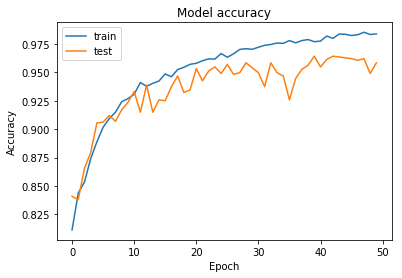

In [17]:
#summarize the history of accuracy
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

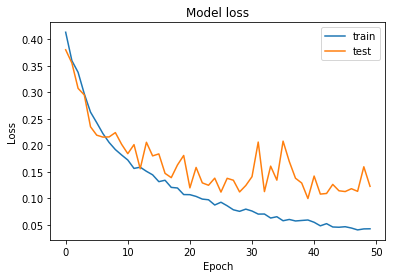

In [18]:
#summarize the history of loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title("Model loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#### Test the model

In [23]:
# evaluate the model
#print(model.metrics_name)
model.evaluate(test_data)

87/87 [==============================] - 200s 2s/step - loss: 0.1509 - accuracy: 0.9580


[0.15086592733860016, 0.9580318331718445]

In [52]:
# predict any specific image
# change "normal" --> "covid" for covid CXRs
test_files = glob("covid_vs_nor/test/normal/*.png")

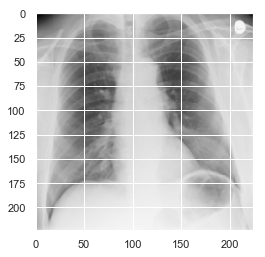

P(covid) vs P(normal): 0.000 vs 1.000


In [53]:
# read any test images
image = cv2.imread(np.random.choice(test_files))
image = cv2.resize(image, (224,224))
preds = model.predict(np.expand_dims(image, axis=0))[0]

plt.imshow(image, cmap='gray')
plt.show()

print("P(covid) vs P(normal): {:.3f} vs {:.3f}".format(preds[0], preds[1]))

#### Find the confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix #plot_confusion_matrix
import seaborn as sn

In [39]:
preds = model.predict(test_data)
y_pred = preds.argmax(axis=1)
y_true = test_data.classes

In [40]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[334,  28],
       [ 37, 983]], dtype=int64)

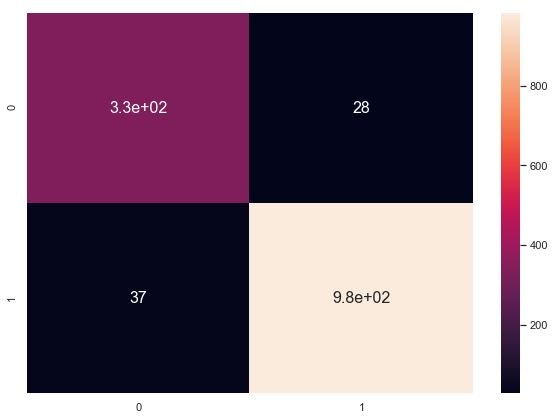

In [46]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

#### Save the trained model to JSON format

In [51]:
#It is the best practice of converting the model into JSON format to save ti for the interence program in the future
model_json = model.to_json()
with open("models/vgg16/vgg16_model_v2.json", "w") as json_file:
    json_file.write(model_json)

#### Load the saved model, compile and evaluate the model later  as follows

In [14]:
# if you want to load the weights in a new notebook
# make sure you have build the "model" object first and then complie the model
# before loading the weights. Otherwise it will through you errors

"""
    model = VGG_16()
    from keras.optimizers import SGD, Adam
    opt = Adam(1e-4)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
"""

model.load_weights("models/vgg16/best_model_v2.h5")

In [ ]:
model.evaluate(test_data)

### 3. Inference the  program

#### Import the necessary libraries if you start inferencing in a new notebook

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from keras.models import model_from_json
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


#### Read the saved JSON model

In [2]:
json_file = open("models/vgg16/vgg16_model_v2.json", "r")
saved_json_model = json_file.read()
json_file.close()

saved_model = model_from_json(saved_json_model)
saved_model.load_weights("models/vgg16/best_model_v2.h5")

#### Compile the model

In [3]:
opt = Adam(1e-4)
saved_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#### Test with any specific image

In [6]:
# Load the image file list
# change "normal" --> "covid" for covid CXRs
test_files = glob.glob("covid_vs_nor/test/covid/*.png")

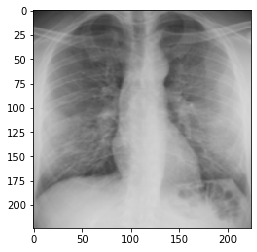

P(covid) vs P(normal): 0.999 vs 0.001


In [7]:
# read any test images
image = cv2.imread(np.random.choice(test_files))
image = cv2.resize(image, (224,224))
preds = saved_model.predict(np.expand_dims(image, axis=0))[0]

plt.imshow(image, cmap='gray')
plt.show()

print("P(covid) vs P(normal): {:.3f} vs {:.3f}".format(preds[0], preds[1]))